# Figures S15, S16a, and S17

This notebook loads the data and produces figures S15, S16a, and S17.

In [1]:
plotsavedate = '20251031'

In [2]:
data_path = '' # path to data
figure_data_folder  = '' # path to downloaded data
data_path2 = '' # secondary data path

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import statsmodels.api as sm
import copy
DC_STATEHOOD=True
import us

# Load and Compile Data

In [4]:
# Load data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

for idx in df_bg_level['STATEFP'].unique():
    inds = df_bg_level[df_bg_level['STATEFP']==idx].index
    try:
        abbr = us.states.lookup(idx).abbr
    except:
        print(idx)
    df_bg_level.loc[inds, 'STATE_abbr'] = abbr
df_bg_level.loc[df_bg_level[df_bg_level['STATEFP']=='11'].index, 'STATE_abbr'] = 'DC'

# State-level Gini coefficient
tmp0 = df_bg_level.groupby('STATEFP')[['Gini_state']].mean().reset_index()
for i in tmp0.index:
    if tmp0.loc[i, 'STATEFP'] == '11':
        tmp0.loc[i, 'STUSPS'] = 'DC'
    else:
        tmp0.loc[i, 'STUSPS'] = us.states.lookup(tmp0.loc[i, 'STATEFP']).abbr
        
# Load regression coefficients
coeffs_by_state = pd.read_csv(figure_data_folder + 'FigureData/figure6b_nbdadvantage_coefficients_bystate.csv', index_col=0)
coeffs_by_state = coeffs_by_state.T.reset_index().rename(columns={'index':'STUSPS', 
                                                                  'median_household_income_imputed_10k':'localBG_10km',
                                                                  'av_income_10km_withoutBG_imputed_10k':'neighBG_10km'})

# Combine
df_plot = coeffs_by_state.merge(tmp0[['STUSPS', 'Gini_state']], on='STUSPS', how='outer')

# State-level Moran coefficient
df_moran = df_bg_level.groupby('STATE_abbr')['Moran_state'].mean().reset_index().rename(columns={'STATE_abbr':'STUSPS'})
df_plot = df_plot.merge(df_moran, on='STUSPS', how='outer')

# Policy count
policies_ongoing = pd.read_csv(data_path2 + 'laws_and_incentives (Jul 21 2025).csv')
policies_expired = pd.read_csv(data_path2 + 'laws_and_incentives (Jul 21 2025) (1).csv')

def add_years(policies):
    
    policies['Enacted Year'] = pd.to_datetime(policies['Enacted Date']).dt.year
    policies['Status Year'] = pd.to_datetime(policies['Status Date']).dt.year
    policies['Start Year'] = policies[['Enacted Year', 'Status Year']].min(axis=1)
    
    policies['Expired Year'] = pd.to_datetime(policies['Expired Date']).dt.year
    policies['Repealed Year'] = pd.to_datetime(policies['Repealed Date']).dt.year
    policies['End Year'] = policies[['Expired Year', 'Repealed Year']].min(axis=1)
    
    return policies

policies_ongoing = add_years(policies_ongoing)
policies_expired = add_years(policies_expired)

policy_df = policies_ongoing.loc[((policies_ongoing['Start Year'] <= 2022)|policies_ongoing['Start Year'].isna())&((policies_ongoing['End Year']>2023)|policies_ongoing['End Year'].isna())]
policy_df = pd.concat((policy_df, policies_expired.loc[((policies_ongoing['Start Year'] <= 2022)|policies_expired['Start Year'].isna())&((policies_expired['End Year']>2023)|policies_expired['End Year'].isna())]), axis=0)

# Combine
df_plot = df_plot.merge(pd.DataFrame(policy_df.groupby('State')['Law Id'].count()).reset_index().rename(columns={'State':'STUSPS', 'Law Id':'Policy count'}), 
                        on='STUSPS', how='outer')

11


# Plot

In [5]:
def stars(pval):
    if pval < 0.05:
        if pval < 0.01:
            if pval < 0.001:
                return "***"
            else:
                return "**"
        else:
            return '*'
    else:
        return ''

### Figure S15

Model 0: [-0.004003   -0.00037889] [0.1713605  0.00161367]
Model 1: [0.02250449 0.000906  ] [0.01471091 0.01262386]


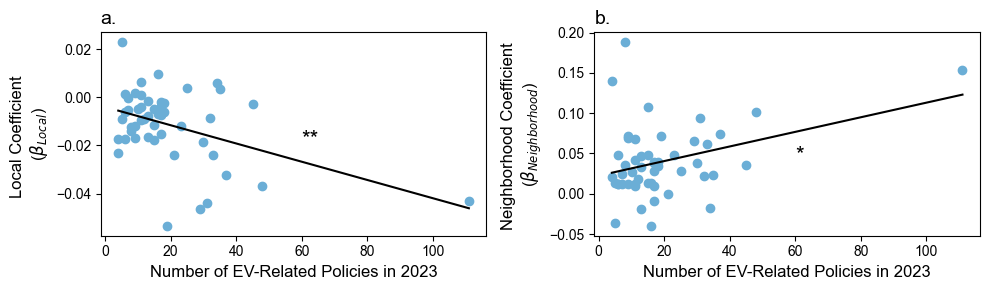

In [7]:
linecolor='k'
dotcolor='#6baed6'


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(df_plot['Policy count'], df_plot['localBG_10km'], color=dotcolor)
axes[0].set_xlabel('Number of EV-Related Policies in 2023', fontsize=12)
axes[0].set_ylabel('Local Coefficient \n($\\beta_{Local}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Policy count'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['localBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[0].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[0].annotate(stars(model.pvalues[1]), (60, -0.02), fontsize=16, color=linecolor)

print('Model 0:', model.params, model.pvalues)

axes[1].scatter(df_plot['Policy count'], df_plot['neighBG_10km'], color=dotcolor)
axes[1].set_xlabel('Number of EV-Related Policies in 2023', fontsize=12)
axes[1].set_ylabel('Neighborhood Coefficient \n($\\beta_{Neighborhood}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Policy count'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['neighBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[1].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[1].annotate(stars(model.pvalues[1]), (60, 0.04), fontsize=16, color=linecolor)

print('Model 1:', model.params, model.pvalues)

axes[0].set_title('a.', loc='left', fontsize=14)
axes[1].set_title('b.', loc='left', fontsize=14)

plt.tight_layout()
plt.savefig('Figures/figureS_policy_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figureS_policy_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()

### Figure S16a

Model 0: [-0.03268784  0.0856619 ] [0.06843639 0.22300641]
Model 1: [ 0.05587688 -0.06447122] [0.29504745 0.75888078]


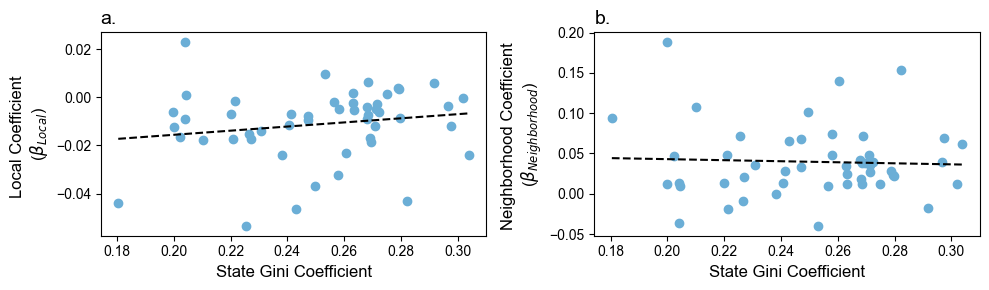

In [8]:

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(df_plot['Gini_state'], df_plot['localBG_10km'], color=dotcolor)
axes[0].set_xlabel('State Gini Coefficient', fontsize=12)
axes[0].set_ylabel('Local Coefficient \n($\\beta_{Local}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Gini_state'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['localBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[0].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[0].annotate(stars(model.pvalues[1]), (0.19, -0.009), fontsize=16, color=linecolor)

print('Model 0:', model.params, model.pvalues)


axes[1].scatter(df_plot['Gini_state'], df_plot['neighBG_10km'], color=dotcolor)
axes[1].set_xlabel('State Gini Coefficient', fontsize=12)
axes[1].set_ylabel('Neighborhood Coefficient \n($\\beta_{Neighborhood}$)', fontsize=12)# in \n# Stations ~ $\\beta_1$ CT Income + $\\beta_2$ 10km Income

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Gini_state'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['neighBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[1].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[1].annotate(stars(model.pvalues[1]), (0.19, 0.025), fontsize=16, color=linecolor)

print('Model 1:', model.params, model.pvalues)


axes[0].set_title('a.', loc='left', fontsize=14)
axes[1].set_title('b.', loc='left', fontsize=14)


plt.tight_layout()
plt.savefig('Figures/figureS_gini_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figureS_gini_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()

### Figure S17

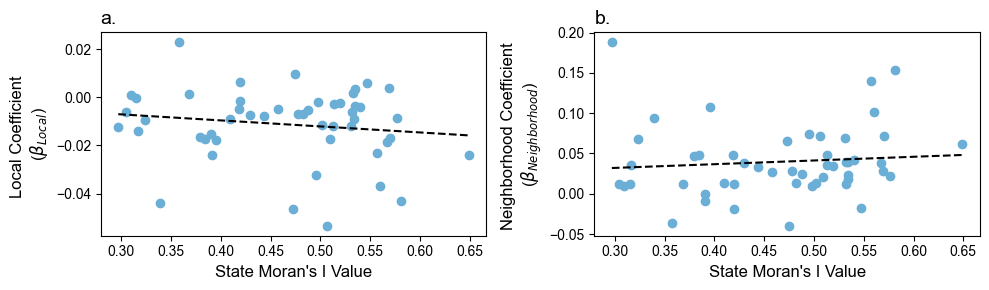

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(df_plot['Moran_state'], df_plot['localBG_10km'], color=dotcolor)
axes[0].set_xlabel("State Moran's I Value", fontsize=12)
axes[0].set_ylabel('Local Coefficient \n($\\beta_{Local}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Moran_state'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['localBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[0].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[0].annotate(stars(model.pvalues[1]), (0.35, -0.02), fontsize=16, color=linecolor)


axes[1].scatter(df_plot['Moran_state'], df_plot['neighBG_10km'], color=dotcolor)
axes[1].set_xlabel("State Moran's I Value", fontsize=12)
axes[1].set_ylabel('Neighborhood Coefficient \n($\\beta_{Neighborhood}$)', fontsize=12)

X = df_plot[df_plot.isna().sum(axis=1) == 0]['Moran_state'].values
X = sm.add_constant(X)
y = df_plot[df_plot.isna().sum(axis=1) == 0]['neighBG_10km'].values
model = sm.OLS(y, X).fit()
xvals = X[:, 1]
if model.pvalues[1] < 0.05:
    linestyle = '-'
else:
    linestyle = '--'
axes[1].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color=linecolor, linestyle=linestyle)
axes[1].annotate(stars(model.pvalues[1]), (0.35, 0.0), fontsize=16, color=linecolor)


axes[0].set_title('a.', loc='left', fontsize=14)
axes[1].set_title('b.', loc='left', fontsize=14)


plt.tight_layout()
plt.savefig('Figures/figureS_moran_state_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figureS_moran_state_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()